<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/HW/hw11/nn_hw11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [NN HW11](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/07-gan/gan.ipynb "NN HW11")

ДЗ - обучаем CGAN - на вход генератору подаём не только шум, но и лейбл, на выход получаем изображения указанного лейбла. Для реализации в дискриминаторе тоже нужен лейбл;)

---

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

In [2]:
import tensorflow as tf

import keras.layers as L
import keras.utils as U
from keras.layers import Dense, Dropout, Input, LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.13.1


## *Параметры обучения*

In [0]:
model_name = 'nn_hw11_cgan_mnist'

n_epoch = 20000
batch_size = 64
latent_size = 100 # the latent or z vector is 100-dim

optimizer_params ={ 'lr' : 2e-4, 'beta_1' : 0.5 }

## *Загрузка данных*

И настройка `Input` слоёв.

In [0]:
(X_train, y_train), (_, _) = mnist.load_data()

X_train = (X_train.astype(np.float32) - 255./2) / (255./2) # tanh activation in generator
image_size = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], np.prod(X_train.shape[1:]))

num_labels = np.amax(y_train) + 1
y_train = U.to_categorical(y_train)

labels = Input(shape=(num_labels, ), name='class_labels')

images = Input(shape=(X_train.shape[1], ), name='discriminator_input')

znoise = Input(shape=(latent_size, ), name='z_input')

adam = Adam(**optimizer_params)

Структура каждой из сетей ниже повторяет ту, которую мы рассматривали на [соответствующем занятии](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/07-gan/gan.ipynb).

## *Discriminator*

In [0]:
def build_discriminator(images, labels):    
    m = L.merge.concatenate([images, labels], axis=1)

    m = Dense(1024)(m)
    m = LeakyReLU(0.2)(m)
    m = Dropout(0.3)(m)
       
    m = Dense(512)(m)
    m = LeakyReLU(0.2)(m)
    m = Dropout(0.3)(m)
       
    m = Dense(256)(m)
    m = LeakyReLU(0.2)(m)
    
    m = Dense(1, activation='sigmoid')(m)
    
    m = Model([images, labels], m, name='discriminator')

    return m

In [0]:
def create_discriminator(inputs, labels, optimizer):
    discriminator = build_discriminator(inputs, labels)    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])    
    discriminator.summary()    
    return discriminator

In [8]:
discriminator = create_discriminator(images, labels, adam)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input (InputLayer (None, 784)          0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           discriminator_input[0][0]        
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         814080      concatenate_1[0][0]              
__________

## *Generator*

In [0]:
def build_generator(znoise, labels):
    m = L.merge.concatenate([znoise, labels], axis=1)

    m = Dense(256)(m)
    m = LeakyReLU(0.2)(m)
    
    m = Dense(512)(m)
    m = LeakyReLU(0.2)(m)
    
    m = Dense(1024)(m)
    m = LeakyReLU(0.2)(m)
    
    m = Dense(784, activation='tanh')(m)

    return  Model(inputs=[znoise, labels], outputs=m, name='generator')

In [0]:
def create_generator(inputs, labels):
    generator = build_generator(inputs, labels)
    generator.summary()    
    return generator

In [11]:
generator = create_generator(znoise, labels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 110)          0           z_input[0][0]                    
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          28416       concatenate_2[0][0]              
__________

## *GAN*

In [0]:
def create_gan(model_name, znoise, labels, generator, discriminator, optimizer):
    img_inputs = generator([znoise, labels])
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    outputs = discriminator([img_inputs, labels])
    gan = Model([znoise, labels], outputs, name=model_name)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    gan.summary()
    
    return gan

In [13]:
# build adversarial model = generator + discriminator
gan = create_gan(model_name, znoise, labels, generator, discriminator, adam)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 784)          1488912     z_input[0][0]                    
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1470465     generator[1][0]                  
          

## *Обучение*

Идея кода для обучения в целом взята из [\[2\]](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter4-gan/cgan-mnist-4.3.1.py "Advanced Deep Learning with Keras").

In [0]:
def plot_generated_images(ax, generator, znoise, labels, image_size):
    generated_images = generator.predict([znoise, labels])
    generated_images = generated_images.reshape(generated_images.shape[0], image_size, image_size)
    for i in range(generated_images.shape[0]):        
        ax[i].imshow(generated_images[i], interpolation='nearest', cmap='gray')
        ax[i].set_xlabel(f'{np.argmax(labels[i])}')
        ax[i].tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

In [0]:
def plot_train_progress(ax, epoch, dloss, dacc, gloss, generator, znoise, labels, image_size=image_size):
    ax[len(ax) // 2].set_title(f'[epoch={epoch}] [D loss={dloss:.3f}] [D acc={dacc:.3f}] [G loss={gloss:.3f}]')
    plot_generated_images(ax, generator, znoise, labels, image_size)

In [0]:
def train_models(model_name, generator, discriminator, gan,
                 X_train, y_train, n_plots=5,
                 image_size=image_size, num_labels=num_labels,
                 n_epoch=n_epoch, batch_size=batch_size, latent_size=latent_size):
    
    # to track how generator learns
    noise_input = np.random.normal(0, 1, [num_labels, latent_size])
    noise_class = np.flip(np.eye(num_labels), 1)
    fig = plt.figure(figsize=(num_labels*1.5, n_plots*2))
    ax = fig.subplots(n_plots, num_labels)                     
                          
    for i in range(n_epoch):
        # real images
        rand_ix = np.random.choice(X_train.shape[0], batch_size, replace=False)
        real_images = X_train[rand_ix]
        real_labels = y_train[rand_ix]
        
        # fake images
        noise = np.random.normal(0, 1, [batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
        # generate fake images conditioned on fake labels
        fake_images = generator.predict([noise, fake_labels])
        
        # real + fake images = 1 batch of train data
        X = np.concatenate((real_images, fake_images))
        # real + fake one-hot labels = 1 batch of train one-hot labels
        labels = np.concatenate((real_labels, fake_labels))

        # label real and fake images
        # real images label is 1.0
        y = np.full([2 * batch_size, 1], 1.0)
        # fake images label is 0.0
        y[batch_size:, :] = 0.0

        # train discriminator network
        discriminator.trainable = True
        dloss, dacc = discriminator.train_on_batch([X, labels], y)

        # train GAN network for 1 batch
        noise = np.random.normal(0, 1, [batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
        # label fake images as real or 1.0
        y = np.full([batch_size, 1], 1.0)
        # train the adversarial network 
        discriminator.trainable = False
        gloss = gan.train_on_batch([noise, fake_labels], y)
        
        if (i + 1) % (n_epoch // n_plots) == 0:
            plot_train_progress(ax[i // (n_epoch // n_plots)], i + 1, dloss, dacc, gloss,
                                generator, noise_input, noise_class)

    return generator

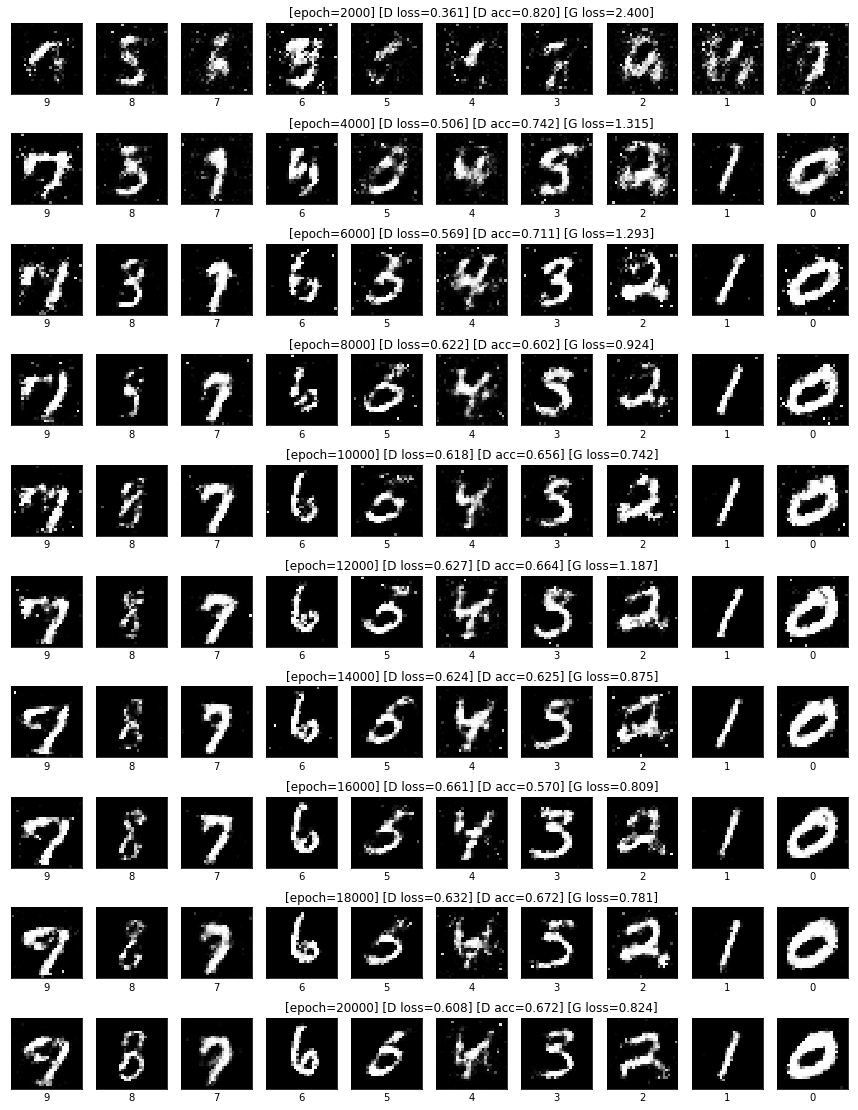

In [17]:
generator = train_models(model_name, generator, discriminator, gan, X_train, y_train, n_plots=10)

In [0]:
# save the model after training the generator
generator.save(model_name + ".h5")

## *Рисуем цифры по запросу*

In [0]:
def generate_and_plot(generator, numbers, image_size=image_size, latent_size=latent_size):
    numbers = np.array(numbers)
    num_labels = len(numbers)
    noise_input = np.random.normal(0, 1, [num_labels, latent_size])
    noise_class = np.eye(10)[numbers % 10]
    fig, ax = plt.subplots(1, num_labels, figsize=(2*num_labels, 1.8), squeeze=False)
    plot_generated_images(ax[0], generator, noise_input, noise_class, image_size)

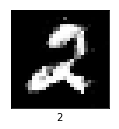

In [20]:
generate_and_plot(generator, [2])

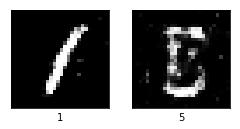

In [21]:
generate_and_plot(generator, [1, 5])

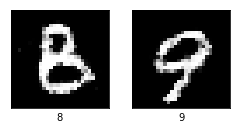

In [22]:
generate_and_plot(generator, [8, 9])

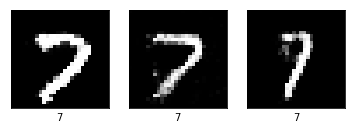

In [23]:
generate_and_plot(generator, [7, 7, 7])

### *References*

[1] [Advanced Deep Learning with Keras](https://www.packtpub.com/big-data-and-business-intelligence/advanced-deep-learning-keras "PacktPub.com | Advanced Deep Learning with Keras")

[2] https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter4-gan/cgan-mnist-4.3.1.py

[3] https://github.com/miranthajayatilake/CGAN-Keras

[4] https://github.com/eriklindernoren/Keras-GAN/tree/master/cgan

[5] https://medium.com/@jonathan_hui/gan-cgan-infogan-using-labels-to-improve-gan-8ba4de5f9c3d